In [1]:
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import scale

import mlgrad.func as func
import mlgrad.avragg as avragg
import mlgrad.mlocation_scatter2 as mlocation_scatter

from mlgrad import averager_it

import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['seaborn-notebook', 'seaborn-white', 'seaborn-ticks'])

import pandas as pd

import matplotlib as mpl
mpl.rcParams['figure.autolayout'] = True

/tmp/ipykernel_152158/3256078564.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-notebook', 'seaborn-white', 'seaborn-ticks'])
/tmp/ipykernel_152158/3256078564.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use(['seaborn-notebook', 'seaborn-white', 'seaborn-ticks'])
/tmp/ipykernel_152158/3256078564.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remai

In [2]:
def permutate_values(Yp, Y, m):
    d = {}
    for yp,y in zip(Yp, Y):
        c = d.setdefault((yp,y), 0)
        d[(yp,y)] = c+1
    print(d)
    values = np.array(list(d.values()))
    keys = list(d.keys())
    indices = list(np.argsort(values))
    keys = [keys[indices[-i]] for i in range(1,m+1)]
    print(keys)
    d = dict(keys)
    for i in range(len(Y)):
        yp = Yp[i]
        Yp[i] = d[yp]

In [3]:
sdata = pd.read_csv("data/cbb/s3.txt", names=['x1', 'x2'], sep='\s+')

In [4]:
X = np.c_[sdata['x1'], sdata['x2']]
X = np.ascontiguousarray(X, 'd')
X = scale(X)  
print(len(X))
print(X)

5000
[[-0.219953    0.60699134]
 [ 0.12250878  0.54691168]
 [ 0.10222994  0.87719143]
 ...
 [-0.73792574 -0.75979444]
 [-0.79094982 -0.72623309]
 [-0.62103372 -1.01226373]]


In [5]:
x1_min, x1_max = X[:,0].min(), X[:,0].max()
x2_min, x2_max = X[:,1].min(), X[:,1].max()
x_min = min(x1_min, x2_min)
x_max = max(x1_max, x2_max)
extent = (x_min, x_max, x_min, x_max)
xrange1 = np.linspace(x_min, x_max, 100)
xrange2 = np.linspace(x_min, x_max, 100)
XX1, XX2, = np.meshgrid(xrange1, xrange2)
XX = np.c_[XX1.ravel(), XX2.ravel()]

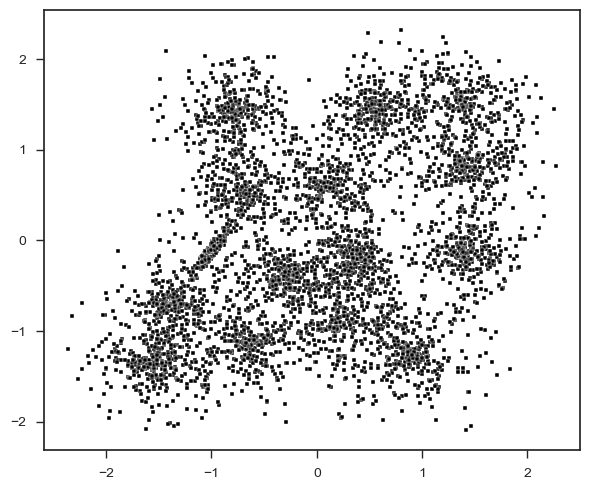

In [6]:
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c='k', edgecolors='w', marker='s', s=9)
plt.show()

In [7]:
alpha = 0.9

In [8]:
# avgmin = avragg.SoftMinimal(2.0)
avgmin = avragg.Minimal()
avrfunc = averager_it(func.QuantileFunc(alpha, func.Sqrt(0.001)))
# avrfunc = averager_it(func.QuantileFunc(alpha, func.Power(1.01, 0.001)))
avrfunc = avragg.ParameterizedAverage(func.WinsorizedSmoothFunc(func.Sqrt(0.001)), avrfunc)
hcd = mlocation_scatter.MLocationsScattersEstimator(avrfunc, avgmin, 15, 
                                    tol=1.0e-7, n_iter=1000, n_step=200)

In [9]:
hcd.fit(X)

In [10]:
# plt.figure(figsize=(10,4))
# plt.subplot(1,2,1)
# plt.plot(hcd.dvals)
# plt.subplot(1,2,2)
# plt.plot(hcd.dvals2)
# plt.show()

In [11]:
D = hcd.evaluate_dist(XX)
DD = D.reshape(XX1.shape)
print(D.min(), D.max())

3.1047695871946666e-06 3.6757142753504795


In [12]:
# plt.figure(figsize=(8,7))
# plt.scatter(X[:,0], X[:,1], c='k', edgecolors='w', marker='s', s=9)
# plt.contour(DD, origin='lower', extent=extent, 
#             levels=np.linspace(0.0,D.max(),100), colors='grey', linewidths=0.5)
# plt.scatter(hcd.locs[:,0], hcd.locs[:,1], c='k', edgecolors='k', s=100)
# plt.show()

In [13]:
# avgmin = avragg.SoftMinimal(2.0)
avgmin2 = avragg.Minimal()
avrfunc2 = averager_it(func.QuantileFunc(alpha, func.Sqrt(0.001)))
# avrfunc = averager_it(func.QuantileFunc(alpha, func.Power(1.01, 0.001)))
avrfunc2 = avragg.ParameterizedAverage(func.WinsorizedSmoothFunc(func.Sqrt(0.001)), avrfunc2)
hcd2 = mlocation_scatter.MLocationsScattersEstimator(avrfunc2, avgmin2, 15, 
                                    tol=1.0e-7, n_iter=1000, n_step=200)

In [14]:
hcd2.fit(X, only='locations')

In [15]:
D_2 = hcd2.evaluate_dist(XX)
DD_2 = D_2.reshape(XX1.shape)
print(D_2.min(), D_2.max())

1.3302707463070503e-05 3.430968844252244


### Среднее арифметическое

In [16]:
arith = avragg.ArithMean()
km = mlocation_scatter.MLocationsScattersEstimator(arith, avgmin, 15, 
                                    tol=1.0e-7, n_iter=1000, n_step=200)

In [17]:
km.fit(X)

In [18]:
# plt.figure(figsize=(10,4))
# plt.subplot(1,2,1)
# plt.plot(km.dvals)
# plt.subplot(1,2,2)
# plt.plot(km.dvals2)
# plt.show()

In [19]:
D2 = km.evaluate_dist(XX)
DD2 = D2.reshape(XX1.shape)
print(D2.min(), D2.max())

7.854110438007795e-05 3.489387372875903


In [20]:
# plt.figure(figsize=(7,6))
# plt.contour(DD2, origin='lower', extent=extent, 
#             levels=np.linspace(0.,D2.max(),100), colors='grey', linewidths=0.5)
# plt.scatter(X[:,0], X[:,1], c='k', edgecolors='w', marker='s', s=9)
# plt.scatter(km.locs[:,0], km.locs[:,1], c='k', edgecolors='w', s=100)
# plt.show()

In [21]:
arith2 = avragg.ArithMean()
km2 = mlocation_scatter.MLocationsScattersEstimator(arith2, avgmin, 15, 
                                    tol=1.0e-7, n_iter=1000, n_step=200)

In [22]:
km2.fit(X, only='locations')

In [23]:
D2_2 = km2.evaluate_dist(XX)
DD2_2 = D2_2.reshape(XX1.shape)
print(D2_2.min(), D2_2.max())

5.958625747713815e-06 3.087192754375892


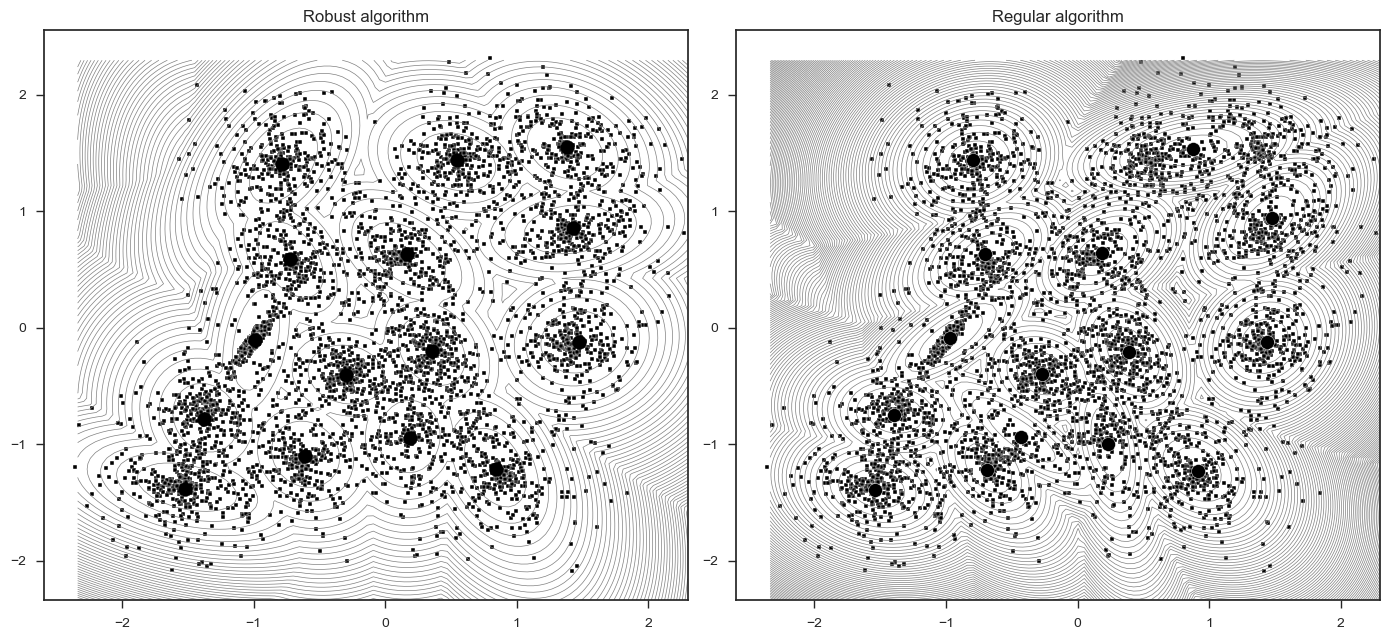

In [24]:
plt.figure(figsize=(14,6.5))

plt.subplot(1,2,1)
plt.title('Robust algorithm')
plt.contour(DD, origin='lower', extent=extent, 
            levels=np.linspace(0.,D.max(),50), colors='grey', linewidths=0.5)
plt.scatter(X[:,0], X[:,1], c='k', edgecolors='w', marker='s', s=9)
plt.scatter(hcd.locs[:,0], hcd.locs[:,1], c='k', edgecolors='k', s=100)

plt.subplot(1,2,2)
plt.title('Regular algorithm')
plt.contour(DD2, origin='lower', extent=extent, 
            levels=np.linspace(0.,D2.max(),100), colors='grey', linewidths=0.5)
plt.scatter(X[:,0], X[:,1], c='k', edgecolors='w', marker='s', s=9)
plt.scatter(km.locs[:,0], km.locs[:,1], c='k', edgecolors='w', s=100)
plt.savefig('fig/robust_kmeans_center_variance_s4.eps')
plt.tight_layout()
plt.show()

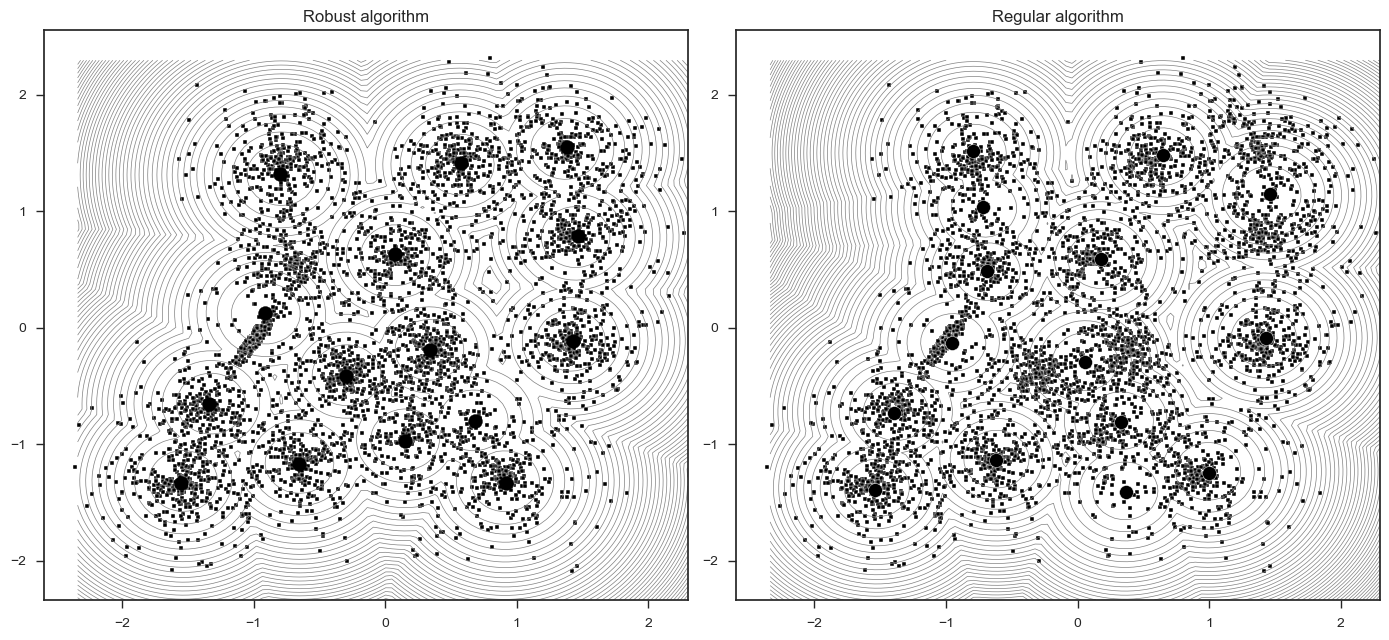

In [25]:
plt.figure(figsize=(14,6.5))

plt.subplot(1,2,1)
plt.title('Robust algorithm')
plt.contour(DD_2, origin='lower', extent=extent, 
            levels=np.linspace(0.,D_2.max(),50), colors='grey', linewidths=0.5)
plt.scatter(X[:,0], X[:,1], c='k', edgecolors='w', marker='s', s=9)
plt.scatter(hcd2.locs[:,0], hcd2.locs[:,1], c='k', edgecolors='k', s=100)

plt.subplot(1,2,2)
plt.title('Regular algorithm')
plt.contour(DD2_2, origin='lower', extent=extent, 
            levels=np.linspace(0.,D2_2.max(),50), colors='grey', linewidths=0.5)
plt.scatter(X[:,0], X[:,1], c='k', edgecolors='w', marker='s', s=9)
plt.scatter(km2.locs[:,0], km2.locs[:,1], c='k', edgecolors='w', s=100)
plt.savefig('fig/robust_kmeans_center_variance2_s4.eps')
plt.tight_layout()
plt.show()

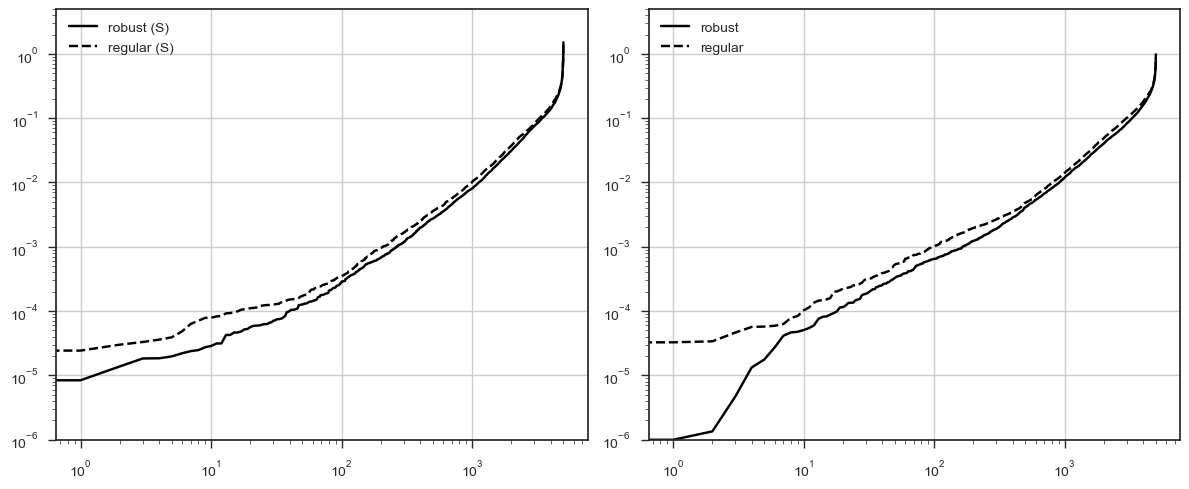

In [26]:
D_1 = hcd.evaluate_dist(X)
D_2 = km.evaluate_dist(X)
D2_1 = hcd2.evaluate_dist(X)
D2_2 = km2.evaluate_dist(X)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.loglog(sorted(D_1), label='robust (S)', c='k')
plt.loglog(sorted(D_2), label='regular (S)', c='k', linestyle='--')
plt.legend()
plt.ylim(1e-6, 5)
plt.grid(1)
plt.subplot(1,2,2)
plt.loglog(sorted(D2_1), label='robust', c='k')
plt.loglog(sorted(D2_2), label='regular', c='k', linestyle='--')
plt.legend()
plt.ylim(1e-6, 5)
plt.grid(1)
plt.savefig('fig/distances_s4.eps')
plt.show()